In [1]:
import glob
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def dict_to_dataframe(data_dict):
    # Initialize an empty list to store each row as a dictionary
    rows = []
    
    # Iterate over each dataset in the dictionary
    for dataset_name, details in data_dict.items():
        # Create a row dictionary for this dataset
        row = {
            'Dataset': dataset_name,
            'num_imgs': len(details['data']),
            'pos_prompts': details['num_pos_pts'],
            'neg_prompts': details['num_neg_pts'],
            'box': details['num_boxes']
        }
        
        # Loop over each class and add metrics for each class
        for class_key, metrics in details.items():
            if class_key.startswith('class_') and isinstance(metrics, dict):
                # Only add specified metrics to the row dictionary
                for metric in ['iou', 'auc', 'dice', 'hd95', 'f1', 'accuracy', 'sensitivity', 'specificity', 'precision', 'mcc', 'assd']:
                    row[f"{class_key}_{metric}"] = metrics.get(metric, None)
        
        # Add mean metrics (overall average)
        if 'main' in details and isinstance(details['main'], dict):
            for metric in ['iou', 'auc', 'dice', 'hd95', 'f1', 'accuracy', 'sensitivity', 'specificity', 'precision', 'mcc', 'assd']:
                row[f"mean_{metric}"] = details['main'].get(metric, None)
        
        # Append the row to the list
        rows.append(row)
    
    # Convert list of rows to DataFrame
    df = pd.DataFrame(rows)
    return df

def combine_dataframes(jfile_list,  rank):
    df_list = []
    for jfile in jfile_list:
        data_dict = json.load(open(jfile, 'r'))
        df = dict_to_dataframe(data_dict)
        # Append the DataFrame to the list
        df_list.append(df)
    
    # Concatenate all DataFrames in the list into a single DataFrame
    combined_df = pd.concat(df_list, ignore_index=True)
    combined_df['rank'] = rank
    combined_df["prompt_type"] = combined_df["pos_prompts"].astype(str) + "_" + combined_df["neg_prompts"].astype(str) + "_" + combined_df["box"].astype(str)
    combined_df = combined_df[[
                "Dataset", 'rank', "prompt_type", "mean_iou", "mean_auc", "mean_dice", "mean_hd95",
                "mean_f1", "mean_accuracy", "mean_sensitivity", "mean_specificity",
                "mean_precision", "mean_mcc", "mean_assd"
            ]].drop_duplicates().sort_values(['Dataset', 'prompt_type'])
    return combined_df


In [3]:
data_dict = json.load(open('results\\od\\fundus_optic_disc_od_sam2_l_r64_a128_e2.json', 'r'))

In [4]:
vessel_vanilla_paths = glob.glob(r"results\vessel\fundus_vessel_vessel_vanilla_sam2_l_e*.json")
vessel_lora32_paths = glob.glob(r"results\vessel\fundus_vessel_od_sam2_l_r32_a64_e*.json")
vessel_lora64_paths = glob.glob(r"results\vessel\fundus_vessel_density_sam2_l_r64_a128_e*.json")
vessel_lora128_paths = glob.glob(r"results\vessel\fundus_vessel_od_sam2_l_r128_a256_e*.json")
vessel_lora256_paths = glob.glob(r"results\vessel\fundus_vessel_od_sam2_l_r256_a512_e*.json")
vessel_lora512_paths = glob.glob(r"results\vessel\fundus_vessel_od_sam2_l_r512_a1024_e*.json")
vessel_lora1024_paths = glob.glob(r"results\vessel\fundus_vessel_od_sam2_l_r1024_a2048_e*.json")


In [5]:
vessel_vanilla_df = combine_dataframes(vessel_vanilla_paths, 0) 
vessel_lora32_df = combine_dataframes(vessel_lora32_paths, 32) 
vessel_lora64_df = combine_dataframes(vessel_lora64_paths, 64) 
vessel_lora128_df = combine_dataframes(vessel_lora128_paths, 128) 
vessel_lora256_df = combine_dataframes(vessel_lora256_paths, 256) 
vessel_lora512_df = combine_dataframes(vessel_lora512_paths, 512) 
vessel_lora1024_df = combine_dataframes(vessel_lora1024_paths,1024) 

In [6]:
vessel_df = pd.concat([
                    vessel_vanilla_df,
                    vessel_lora32_df, 
                    vessel_lora64_df,
                    vessel_lora128_df, 
                    vessel_lora256_df, 
                    vessel_lora512_df, 
                    vessel_lora1024_df
                    ])

In [7]:
vessel_df

,Dataset,rank,prompt_type,mean_iou,mean_auc,mean_dice,mean_hd95,mean_f1,mean_accuracy,mean_sensitivity,mean_specificity,mean_precision,mean_mcc,mean_assd
0,chasedb1,0,0_0_0,0.047017,0.870514,0.086440,500.046395,0.086440,0.916913,0.049618,0.996895,0.418241,0.122407,11.151132
25,chasedb1,0,0_0_1,0.087757,0.798616,0.159744,59.891972,0.159744,0.897981,0.121037,0.969544,0.314380,0.137364,13.724933
5,chasedb1,0,1_0_0,0.071550,0.854967,0.129670,386.981599,0.129670,0.917217,0.077986,0.994956,0.728137,0.193807,11.746067
10,chasedb1,0,2_0_0,0.081422,0.865993,0.147697,384.166359,0.147697,0.916593,0.090214,0.992906,0.695960,0.203674,12.108541
15,chasedb1,0,5_0_0,0.062246,0.862276,0.116599,404.555163,0.116599,0.918001,0.064810,0.996812,0.693623,0.189202,11.689157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29,stare,1024,0_0_1,0.668690,0.961395,0.801185,18.527655,0.801185,0.963139,0.757162,0.985656,0.855930,0.784036,9.973129
9,stare,1024,1_0_0,0.640535,0.960896,0.778385,20.748475,0.778385,0.960708,0.715068,0.988213,0.873569,0.766305,10.194996
14,stare,1024,2_0_0,0.644757,0.960758,0.781479,20.041621,0.781479,0.960961,0.725597,0.987180,0.866547,0.768685,10.120134
19,stare,1024,5_0_0,0.632357,0.961219,0.769778,20.009598,0.769778,0.959462,0.717368,0.986605,0.861218,0.758971,10.361493


In [8]:
vessel_df.to_csv('vessel.csv')

In [9]:
unique_values = vessel_df['Dataset'].unique()

# Define the correct column names for the DataFrame
columns = [
    "rank", "dataset", "mean_iou_mean", "mean_iou_std", "mean_f1_mean", "mean_f1_std",
    "mean_auc_mean", "mean_auc_std", "mean_sensitivity_mean", "mean_sensitivity_std",
    "mean_specificity_mean", "mean_specificity_std", "mean_dice_mean", "mean_dice_std"
]

# Create an empty DataFrame with the correct columns
df = pd.DataFrame(columns=columns)

# Iterate through each unique dataset value
for name in unique_values:
    # Filter and group the data for the current dataset
    _df = vessel_df[vessel_df['Dataset'] == name][[
        'Dataset', 'rank', 'mean_iou', 'mean_dice', 'mean_f1', 
        'mean_auc', 'mean_sensitivity', 'mean_specificity'
    ]].groupby('rank').agg(
        dataset=('Dataset', 'first'),
        mean_iou_mean=("mean_iou", "mean"),
        mean_iou_std=("mean_iou", "std"),
        mean_f1_mean=("mean_f1", "mean"),
        mean_f1_std=("mean_f1", "std"),
        mean_auc_mean=("mean_auc", "mean"),
        mean_auc_std=("mean_auc", "std"),
        mean_sensitivity_mean=("mean_sensitivity", "mean"),
        mean_sensitivity_std=("mean_sensitivity", "std"),
        mean_specificity_mean=("mean_specificity", "mean"),
        mean_specificity_std=("mean_specificity", "std"),
        mean_dice_mean=("mean_dice", "mean"),
        mean_dice_std=("mean_dice", "std"),
    ).reset_index()

    # Concatenate the grouped results to the main DataFrame
    df = pd.concat([df, _df])

# Reset the index of the final DataFrame
df = df.reset_index(drop=True)


C:\Users\Sayan Mandal\AppData\Local\Temp\ipykernel_7628\3863961394.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, _df])


In [10]:
df[df['rank']!=0][["mean_iou_mean", "mean_dice_mean", "mean_auc_mean", "mean_f1_mean", "mean_sensitivity_mean"]].describe()

,mean_iou_mean,mean_dice_mean,mean_auc_mean,mean_f1_mean,mean_sensitivity_mean
count,30.000000,30.000000,30.000000,30.000000,30.000000
mean,0.596155,0.712144,0.940902,0.712144,0.687316
std,0.115731,0.119602,0.044673,0.119602,0.114187
min,0.309859,0.406321,0.819867,0.406321,0.390276
25%,0.555608,0.673754,0.926495,0.673754,0.643072
50%,0.623324,0.742485,0.955151,0.742485,0.703962
75%,0.665931,0.796738,0.975138,0.796738,0.757136
max,0.766070,0.856481,0.984259,0.856481,0.858406


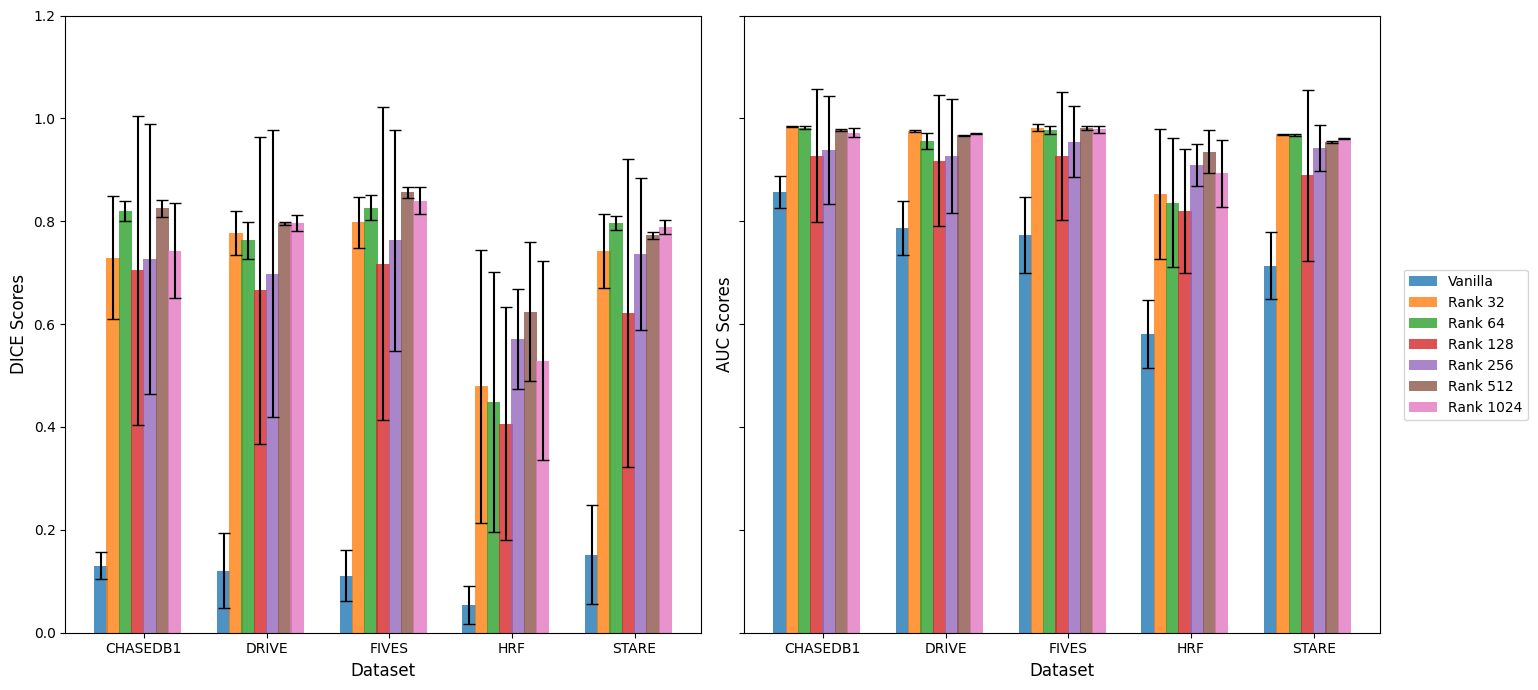

In [14]:
# fig, ax = plt.subplots(figsize=(12, 6))

# Bar width and position adjustment
bar_width = 0.1
ranks = sorted(df["rank"].unique())
whisker_color = 'blue'
whisker_thickness = 2

available_metrics = ["mean_dice_mean", "mean_auc_mean"]#, "mean_f1_mean", "mean_sensitivity_mean" ]
metrics = [metric for metric in available_metrics if metric in df.columns]

x_labels = [l.upper() for l in df["dataset"].unique()]
x = np.arange(len(x_labels))  # x locations for datasets

# Updated chart with side-by-side subplots, dashed error whiskers, and a single legend
fig, axes = plt.subplots(1, len(metrics), figsize=(7 * len(metrics), 7), sharey=True)
colors = plt.cm.tab10.colors  # Use a color palette

# Loop over metrics to create subplots
for k, metric in enumerate(metrics):
    ax = axes[k] if len(metrics) > 1 else axes
    for i, rank in enumerate(ranks):
        subset = df[df["rank"] == rank]
        y = subset[metric]
        std_column = metric.replace("_mean", "_std")  # Correct std column
        yerr = subset[std_column] if std_column in subset.columns else None

        ax.bar(
            x + bar_width * i,  # Adjust position for each rank
            y,
            yerr=yerr,
            width=bar_width * 1.1,  # Slightly widen bars
            label=f"Rank {rank}" if k == 0 else None,  # Add labels only for the first subplot
            color=colors[i % len(colors)],
            error_kw=dict(ecolor="black", elinewidth=1.5, capsize=4, linestyle="--") if yerr is not None else None,
            alpha=0.8,
        )

    # Add titles and labels
    # ax.set_title(metric.replace("_mean", "").replace("_", " ").capitalize(), fontsize=14)
    ax.set_xlabel("Dataset", fontsize=12)
    ax.set_ylabel(metric.replace("mean_", "").replace("_mean", "").upper()+" Scores", fontsize=12)
    ax.set_xticks(x + bar_width * len(ranks) / 2)  # Center the ticks
    ax.set_xticklabels(x_labels)
    ax.set_ylim(0, 1.2)  # Set y-axis limits

# Add a single legend for the entire figure
lgd =fig.legend(
    labels=["Vanilla"]+[f"Rank {rank}" for rank in ranks[1:]],
    loc="right",
    bbox_to_anchor=(1.1, 0.5),
    # ncol=len(ranks),
    fontsize=10,
)

plt.tight_layout()
plt.savefig("vessel_new.png", dpi=200, bbox_extra_artists=[lgd], bbox_inches='tight')

plt.show()

In [15]:
od_vanilla_paths = glob.glob(r"results\od\fundus_optic_disc_od_vanilla_sam2_l_e*.json")
od_lora32_paths = glob.glob(r"results\od\fundus_optic_disc_od_sam2_l_r32_a64_e*.json")
od_lora64_paths = glob.glob(r"results\od\fundus_optic_disc_od_sam2_l_r64_a128_e*.json")
od_lora128_paths = glob.glob(r"results\od\fundus_optic_disc_od_sam2_l_r128_a256_e*.json")
od_lora256_paths = glob.glob(r"results\od\fundus_optic_disc_od_sam2_l_r256_a512_e*.json")
od_lora512_paths = glob.glob(r"results\od\fundus_optic_disc_od_sam2_l_r512_a1024_e*.json")
od_lora1024_paths = glob.glob(r"results\od\fundus_optic_disc_od_sam2_l_r1024_a2048_e*.json")

In [16]:
od_vanilla_df = combine_dataframes(od_vanilla_paths, 0) 
od_lora32_df = combine_dataframes(od_lora32_paths, 32) 
od_lora64_df = combine_dataframes(od_lora64_paths, 64) 
od_lora128_df = combine_dataframes(od_lora128_paths, 128) 
od_lora256_df = combine_dataframes(od_lora256_paths, 256) 
od_lora512_df = combine_dataframes(od_lora512_paths, 512) 
od_lora1024_df = combine_dataframes(od_lora1024_paths,1024) 

In [17]:
od_df = pd.concat([
                    od_vanilla_df,
                    od_lora32_df, 
                    od_lora64_df,
                    od_lora128_df, 
                    od_lora256_df, 
                    od_lora512_df, 
                    od_lora1024_df
                    ])

In [18]:
od_df.to_csv('optic_disc.csv')

In [19]:
od_df[od_df['Dataset']=='refuge2'].describe()

,rank,mean_iou,mean_auc,mean_dice,mean_hd95,mean_f1,mean_accuracy,mean_sensitivity,mean_specificity,mean_precision,mean_mcc,mean_assd
count,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000
mean,288.000000,0.763574,0.989903,0.833124,56.114775,0.833124,0.994711,0.835012,0.997288,0.869111,0.839437,4.965178
std,345.808067,0.221678,0.016206,0.210039,96.786877,0.210039,0.007804,0.224000,0.005809,0.195002,0.204723,2.110926
min,0.000000,0.060952,0.918799,0.105472,7.230245,0.105472,0.952933,0.087241,0.965420,0.077754,0.094568,3.533310
25%,32.000000,0.745182,0.988602,0.838480,9.016941,0.838480,0.994216,0.889869,0.997074,0.838816,0.845439,3.673184
50%,128.000000,0.876894,0.996279,0.931598,12.343623,0.931598,0.997930,0.917045,0.999307,0.954695,0.932076,3.866303
75%,512.000000,0.893114,0.999144,0.942892,40.752515,0.942892,0.998270,0.955492,0.999642,0.975921,0.943310,5.690451
max,1024.000000,0.918153,0.999898,0.957101,444.718454,0.957101,0.998657,0.986356,0.999792,0.983081,0.956741,13.662322


In [20]:
unique_values = od_df['Dataset'].unique()

# Define the correct column names for the DataFrame
columns = [
    "rank", "dataset", "mean_iou_mean", "mean_iou_std", "mean_f1_mean", "mean_f1_std",
    "mean_auc_mean", "mean_auc_std", "mean_sensitivity_mean", "mean_sensitivity_std",
    "mean_specificity_mean", "mean_specificity_std", "mean_dice_mean", "mean_dice_std"
]

# Create an empty DataFrame with the correct columns
df = pd.DataFrame(columns=columns)

# Iterate through each unique dataset value
for name in unique_values:
    # Filter and group the data for the current dataset
    _df = od_df[od_df['Dataset'] == name][[
        'Dataset', 'rank', 'mean_iou', 'mean_dice', 'mean_f1', 
        'mean_auc', 'mean_sensitivity', 'mean_specificity'
    ]].groupby('rank').agg(
        dataset=('Dataset', 'first'),
        mean_iou_mean=("mean_iou", "mean"),
        mean_iou_std=("mean_iou", "std"),
        mean_f1_mean=("mean_f1", "mean"),
        mean_f1_std=("mean_f1", "std"),
        mean_auc_mean=("mean_auc", "mean"),
        mean_auc_std=("mean_auc", "std"),
        mean_sensitivity_mean=("mean_sensitivity", "mean"),
        mean_sensitivity_std=("mean_sensitivity", "std"),
        mean_specificity_mean=("mean_specificity", "mean"),
        mean_specificity_std=("mean_specificity", "std"),
        mean_dice_mean=("mean_dice", "mean"),
        mean_dice_std=("mean_dice", "std"),
    ).reset_index()

    # Concatenate the grouped results to the main DataFrame
    df = pd.concat([df, _df])

# Reset the index of the final DataFrame
df = df.reset_index(drop=True)


C:\Users\Sayan Mandal\AppData\Local\Temp\ipykernel_7628\598340186.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, _df])


In [18]:
df[df['rank']!=0][["mean_iou_mean", "mean_dice_mean", "mean_auc_mean", "mean_f1_mean", "mean_sensitivity_mean"]].describe()

,mean_iou_mean,mean_dice_mean,mean_auc_mean,mean_f1_mean,mean_sensitivity_mean
count,36.000000,36.000000,36.000000,36.000000,36.000000
mean,0.793654,0.862597,0.992132,0.862597,0.897771
std,0.041581,0.039290,0.006467,0.039290,0.050420
min,0.686154,0.772291,0.972836,0.772291,0.775265
25%,0.760419,0.831654,0.988612,0.831654,0.854633
50%,0.800399,0.876984,0.995110,0.876984,0.913644
75%,0.824727,0.891878,0.996589,0.891878,0.935461
max,0.873722,0.930711,0.998194,0.930711,0.957333


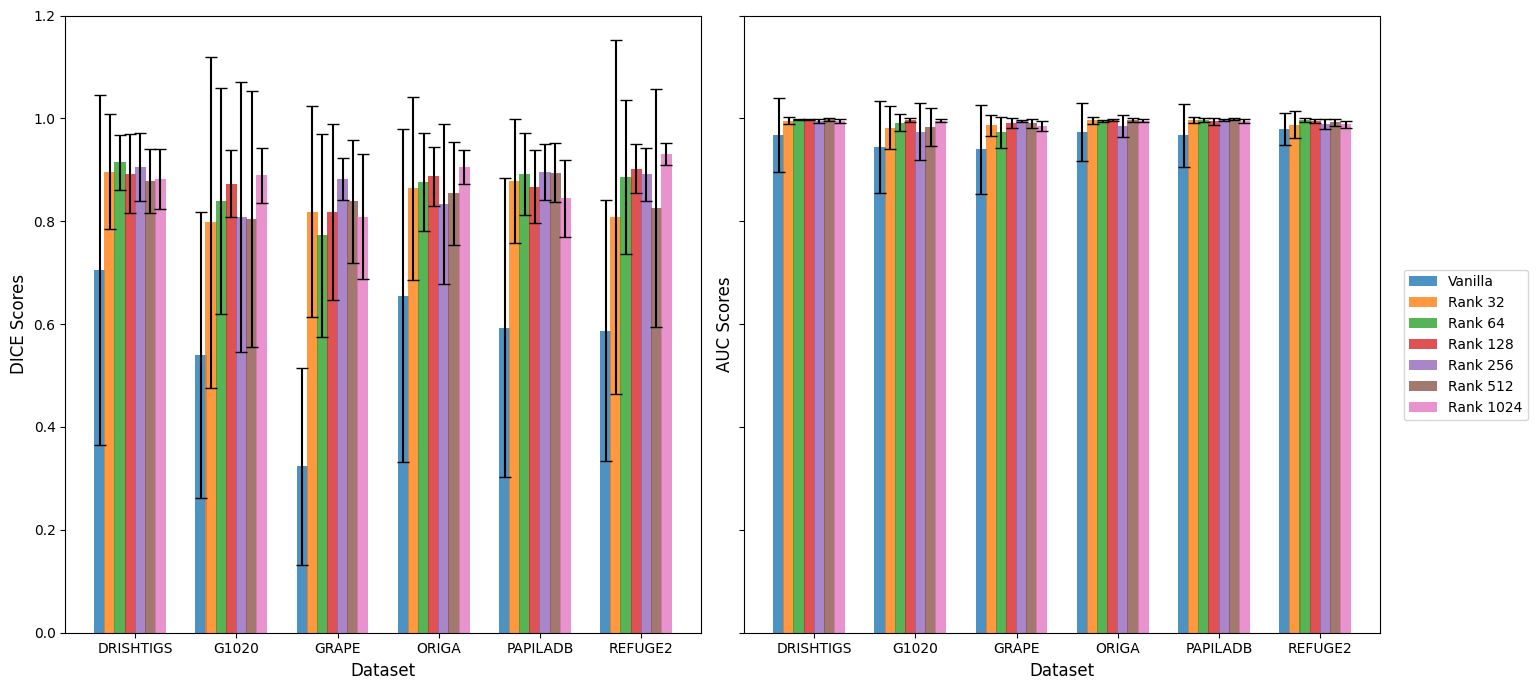

: 

In [22]:
bar_width = 0.1
ranks = sorted(df["rank"].unique())
whisker_color = 'blue'
whisker_thickness = 2

available_metrics = [ "mean_dice_mean", "mean_auc_mean"]#, "mean_f1_mean", "mean_sensitivity_mean" ]
metrics = [metric for metric in available_metrics if metric in df.columns]

x_labels = [l.upper() for l in df["dataset"].unique()]
x = np.arange(len(x_labels))  # x locations for datasets

# Updated chart with side-by-side subplots, dashed error whiskers, and a single legend
fig, axes = plt.subplots(1, len(metrics), figsize=(7 * len(metrics), 7), sharey=True)
colors = plt.cm.tab10.colors  # Use a color palette

# Loop over metrics to create subplots
for k, metric in enumerate(metrics):
    ax = axes[k] if len(metrics) > 1 else axes
    for i, rank in enumerate(ranks):
        subset = df[df["rank"] == rank]
        y = subset[metric]
        std_column = metric.replace("_mean", "_std")  # Correct std column
        yerr = subset[std_column] if std_column in subset.columns else None

        ax.bar(
            x + bar_width * i,  # Adjust position for each rank
            y,
            yerr=yerr,
            width=bar_width * 1.1,  # Slightly widen bars
            label=f"Rank {rank}" if k == 0 else None,  # Add labels only for the first subplot
            color=colors[i % len(colors)],
            error_kw=dict(ecolor="black", elinewidth=1.5, capsize=4, linestyle="--") if yerr is not None else None,
            alpha=0.8,
        )

    # Add titles and labels
    # ax.set_title(metric.replace("_mean", "").replace("_", " ").capitalize(), fontsize=14)
    ax.set_xlabel("Dataset", fontsize=12)
    ax.set_ylabel(metric.replace("mean_", "").replace("_mean", "").upper()+" Scores", fontsize=12)
    ax.set_xticks(x + bar_width * len(ranks) / 2)  # Center the ticks
    ax.set_xticklabels(x_labels)
    ax.set_ylim(0, 1.2)  # Set y-axis limits

# Add a single legend for the entire figure
lgd =fig.legend(
    labels=["Vanilla"]+[f"Rank {rank}" for rank in ranks[1:]],
    loc="right",
    bbox_to_anchor=(1.1, 0.5),
    # ncol=len(ranks),
    fontsize=10,
)

plt.tight_layout()
plt.savefig("optic_disc_new.png", dpi=200, bbox_extra_artists=[lgd], bbox_inches='tight')

plt.show()

In [21]:
oc_vanilla_paths = glob.glob(r"results\cup_only\fundus_optic_disc_vanilla_cup_only_vanilla_sam2_l_e*.json")
oc_lora32_paths = glob.glob(r"results\cup_only\fundus_optic_disc_cup_only_sam2_l_r32_a64_e*.json")
oc_lora64_paths = glob.glob(r"results\cup_only\fundus_optic_disc_cup_only_sam2_l_r64_a128_e*.json")
oc_lora128_paths = glob.glob(r"results\cup_only\fundus_optic_disc_cup_only_sam2_l_r128_a256_e*.json")
oc_lora256_paths = glob.glob(r"results\cup_only\fundus_optic_disc_cup_only_sam2_l_r256_a512_e*.json")
oc_lora512_paths = glob.glob(r"results\cup_only\fundus_optic_disc_cup_only_sam2_l_r512_a1024_e*.json")
oc_lora1024_paths = glob.glob(r"results\cup_only\fundus_optic_disc_cup_only_sam2_l_r1024_a2048_e*.json")

In [22]:
oc_vanilla_df = combine_dataframes(oc_vanilla_paths, 0) 
oc_lora32_df = combine_dataframes(oc_lora32_paths, 32) 
oc_lora64_df = combine_dataframes(oc_lora64_paths, 64) 
oc_lora128_df = combine_dataframes(oc_lora128_paths, 128) 
oc_lora256_df = combine_dataframes(oc_lora256_paths, 256) 
oc_lora512_df = combine_dataframes(oc_lora512_paths, 512) 
oc_lora1024_df = combine_dataframes(oc_lora1024_paths,1024) 

In [23]:
oc_df = pd.concat([
                    oc_vanilla_df,
                    oc_lora32_df, 
                    oc_lora64_df,
                    oc_lora128_df, 
                    oc_lora256_df, 
                    oc_lora512_df, 
                    oc_lora1024_df
                    ])

In [24]:
oc_df[oc_df['Dataset']=='drishtigs'].describe()

,rank,mean_iou,mean_auc,mean_dice,mean_hd95,mean_f1,mean_accuracy,mean_sensitivity,mean_specificity,mean_precision,mean_mcc,mean_assd
count,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000
mean,288.000000,0.597289,0.962764,0.723268,60.548596,0.723268,0.990740,0.705748,0.995990,0.841148,0.742743,5.639106
std,345.808067,0.145731,0.038610,0.145791,104.304317,0.145791,0.006065,0.215023,0.005345,0.183061,0.141690,1.070327
min,0.000000,0.021263,0.831536,0.029576,13.562027,0.029576,0.958712,0.023296,0.975395,0.072181,0.019738,4.368662
25%,32.000000,0.520170,0.930267,0.667540,27.225784,0.667540,0.989666,0.558267,0.994354,0.746180,0.704238,4.873088
50%,128.000000,0.603196,0.969837,0.745308,36.645783,0.745308,0.991675,0.667664,0.997412,0.858445,0.759141,5.395266
75%,512.000000,0.663115,0.998287,0.791859,45.296083,0.791859,0.993637,0.941268,0.999940,0.990101,0.805526,6.119023
max,1024.000000,0.841038,0.999732,0.912372,668.490829,0.912372,0.996882,0.991879,0.999983,0.996154,0.914194,10.202434


In [22]:
unique_values = oc_df['Dataset'].unique()

# Define the correct column names for the DataFrame
columns = [
    "rank", "dataset", "mean_iou_mean", "mean_iou_std", "mean_f1_mean", "mean_f1_std",
    "mean_auc_mean", "mean_auc_std", "mean_sensitivity_mean", "mean_sensitivity_std",
    "mean_specificity_mean", "mean_specificity_std", "mean_dice_mean", "mean_dice_std"
]

# Create an empty DataFrame with the correct columns
df = pd.DataFrame(columns=columns)

# Iterate through each unique dataset value
for name in unique_values:
    # Filter and group the data for the current dataset
    _df = oc_df[oc_df['Dataset'] == name][[
        'Dataset', 'rank', 'mean_iou', 'mean_dice', 'mean_f1', 
        'mean_auc', 'mean_sensitivity', 'mean_specificity'
    ]].groupby('rank').agg(
        dataset=('Dataset', 'first'),
        mean_iou_mean=("mean_iou", "mean"),
        mean_iou_std=("mean_iou", "std"),
        mean_f1_mean=("mean_f1", "mean"),
        mean_f1_std=("mean_f1", "std"),
        mean_auc_mean=("mean_auc", "mean"),
        mean_auc_std=("mean_auc", "std"),
        mean_sensitivity_mean=("mean_sensitivity", "mean"),
        mean_sensitivity_std=("mean_sensitivity", "std"),
        mean_specificity_mean=("mean_specificity", "mean"),
        mean_specificity_std=("mean_specificity", "std"),
        mean_dice_mean=("mean_dice", "mean"),
        mean_dice_std=("mean_dice", "std"),
    ).reset_index()

    # Concatenate the grouped results to the main DataFrame
    df = pd.concat([df, _df])

# Reset the index of the final DataFrame
df = df.reset_index(drop=True)


C:\Users\Sayan Mandal\AppData\Local\Temp\ipykernel_34092\1487062306.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, _df])


In [23]:
df[df['rank']!=0][["mean_iou_mean", "mean_dice_mean", "mean_auc_mean", "mean_f1_mean", "mean_sensitivity_mean"]].describe()

,mean_iou_mean,mean_dice_mean,mean_auc_mean,mean_f1_mean,mean_sensitivity_mean
count,36.000000,36.000000,36.000000,36.000000,36.000000
mean,0.633059,0.748911,0.982205,0.748911,0.804831
std,0.049092,0.042643,0.011628,0.042643,0.056544
min,0.518888,0.652947,0.946761,0.652947,0.686865
25%,0.598496,0.717846,0.980298,0.717846,0.760171
50%,0.630064,0.741555,0.984685,0.741555,0.825384
75%,0.662995,0.776361,0.989523,0.776361,0.847785
max,0.732521,0.837893,0.993544,0.837893,0.877599


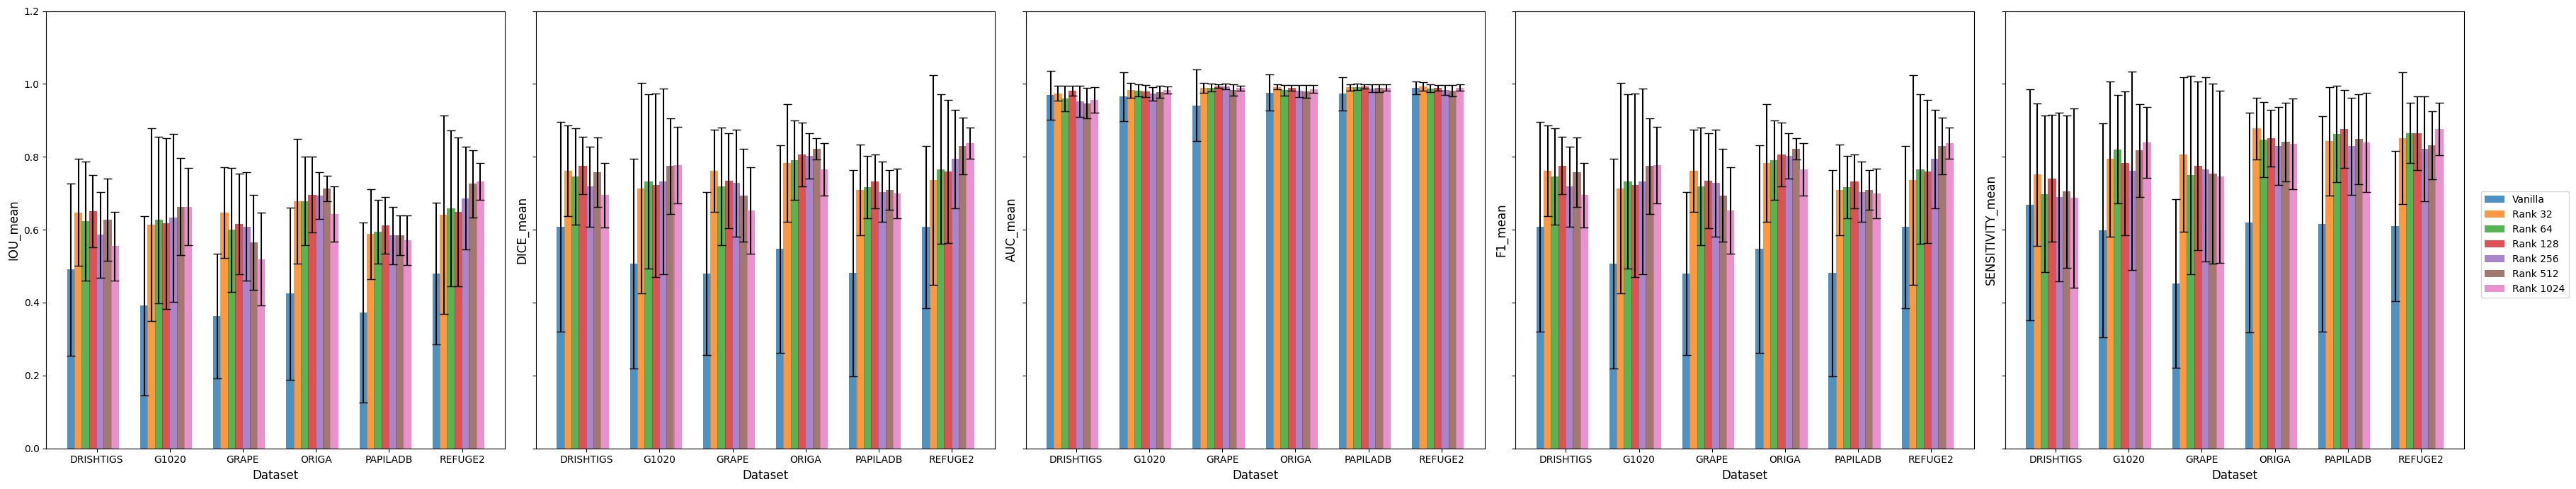

: 

In [ ]:
# fig, ax = plt.subplots(figsize=(12, 6))

# Bar width and position adjustment
bar_width = 0.1
ranks = sorted(df["rank"].unique())
whisker_color = 'blue'
whisker_thickness = 2

available_metrics = ["mean_iou_mean", "mean_dice_mean", "mean_auc_mean", "mean_f1_mean", "mean_sensitivity_mean" ]
metrics = [metric for metric in available_metrics if metric in df.columns]

x_labels = [l.upper() for l in df["dataset"].unique()]
x = np.arange(len(x_labels))  # x locations for datasets

# Updated chart with side-by-side subplots, dashed error whiskers, and a single legend
fig, axes = plt.subplots(1, len(metrics), figsize=(7 * len(metrics), 7), sharey=True)
colors = plt.cm.tab10.colors  # Use a color palette

# Loop over metrics to create subplots
for k, metric in enumerate(metrics):
    ax = axes[k] if len(metrics) > 1 else axes
    for i, rank in enumerate(ranks):
        subset = df[df["rank"] == rank]
        y = subset[metric]
        std_column = metric.replace("_mean", "_std")  # Correct std column
        yerr = subset[std_column] if std_column in subset.columns else None

        ax.bar(
            x + bar_width * i,  # Adjust position for each rank
            y,
            yerr=yerr,
            width=bar_width * 1.1,  # Slightly widen bars
            label=f"Rank {rank}" if k == 0 else None,  # Add labels only for the first subplot
            color=colors[i % len(colors)],
            error_kw=dict(ecolor="black", elinewidth=1.5, capsize=4, linestyle="--") if yerr is not None else None,
            alpha=0.8,
        )

    # Add titles and labels
    # ax.set_title(metric.replace("_mean", "").replace("_", " ").capitalize(), fontsize=14)
    ax.set_xlabel("Dataset", fontsize=12)
    ax.set_ylabel(metric.replace("mean_", "").replace("_mean", "").upper()+"_mean", fontsize=12)
    ax.set_xticks(x + bar_width * len(ranks) / 2)  # Center the ticks
    ax.set_xticklabels(x_labels)
    ax.set_ylim(0, 1.2)  # Set y-axis limits

# Add a single legend for the entire figure
lgd =fig.legend(
    labels=["Vanilla"]+[f"Rank {rank}" for rank in ranks[1:]],
    loc="right",
    bbox_to_anchor=(1.04, 0.5),
    # ncol=len(ranks),
    fontsize=10,
)

plt.tight_layout()
plt.savefig("optic_cup.png", dpi=200, bbox_extra_artists=[lgd], bbox_inches='tight')

plt.show()

In [40]:
import matplotlib.pyplot as plt

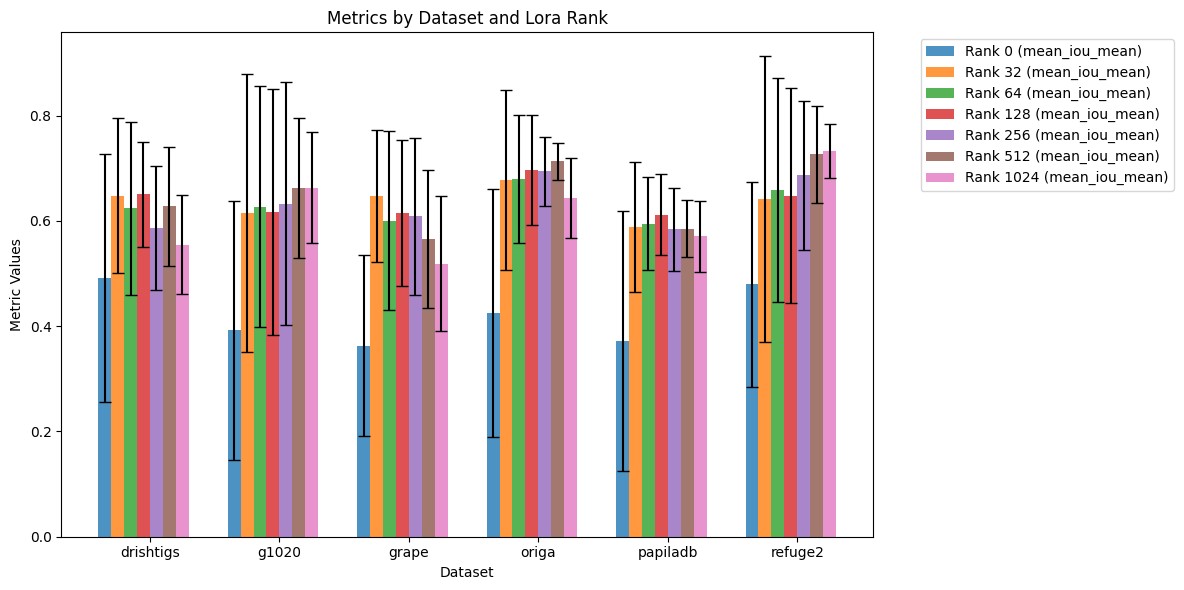

In [42]:
fig, ax = plt.subplots(figsize=(12, 6))

# Define the metrics to be plotted
metrics = ["mean_iou_mean"]
x_labels = df['dataset'].unique()
x = np.arange(len(x_labels))  # x locations for datasets

# Bar width and position adjustment
bar_width = 0.1
ranks = sorted(df["rank"].unique())
colors = plt.cm.tab10.colors  # Use a color palette

# Loop over ranks and plot bars for each metric
for i, rank in enumerate(ranks):
    for j, metric in enumerate(metrics):
        subset = df[df["rank"] == rank]
        y = subset[metric]
        std_column = metric.replace("_mean", "_std")  # Correct std column
        yerr = subset[std_column]
        
        ax.bar(
            x + bar_width * (i * len(metrics) + j),  # Adjust position for rank and metric
            y,
            yerr=yerr,
            width=bar_width,
            label=f"Rank {rank} ({metric})",
            color=colors[i % len(colors)],
            capsize=4,
            alpha=0.8,
        )

# Labeling
ax.set_xticks(x + bar_width * len(ranks) / 2)  # Center the ticks
ax.set_xticklabels(x_labels)
ax.set_title("Metrics by Dataset and Lora Rank")
ax.set_xlabel("Dataset")
ax.set_ylabel("Metric Values")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [3]:
od_vanilla_paths = glob.glob(r"results\vessel\fundus_vessel_vessel_vanilla_sam2_l_e*.json")
od_lora_paths = glob.glob(r"results\od\fundus_optic_disc_od_sam2_l_r64_a128_e*.json")

In [4]:
od_vanilla_df = combine_dataframes(od_vanilla_paths) 
od_lora_df = combine_dataframes(od_lora_paths) 

In [6]:
od_lora_paths

['results\\od\\fundus_optic_disc_od_sam2_l_r64_a128_e0.json',
 'results\\od\\fundus_optic_disc_od_sam2_l_r64_a128_e1.json',
 'results\\od\\fundus_optic_disc_od_sam2_l_r64_a128_e2.json',
 'results\\od\\fundus_optic_disc_od_sam2_l_r64_a128_e3.json',
 'results\\od\\fundus_optic_disc_od_sam2_l_r64_a128_e4.json',
 'results\\od\\fundus_optic_disc_od_sam2_l_r64_a128_e5.json',
 'results\\od\\fundus_optic_disc_od_sam2_l_r64_a128_e6.json']

In [5]:
od_lora_df.iloc[:6].filter(regex='^mean')

,mean_iou,mean_auc,mean_dice,mean_hd95,mean_f1,mean_accuracy,mean_sensitivity,mean_specificity,mean_precision,mean_mcc,mean_assd
0,0.734039,0.996646,0.833268,107.039167,0.833268,0.986948,0.962219,0.987866,0.749884,0.838748,7.097084
1,0.276560,0.957229,0.392678,348.691401,0.392678,0.956884,0.656150,0.962765,0.293086,0.413636,12.605225
2,0.549204,0.934869,0.697929,164.302934,0.697929,0.868877,0.838398,0.881418,0.613452,0.635881,13.269288
3,0.534052,0.994364,0.681638,224.988736,0.681638,0.980104,0.963575,0.980439,0.542778,0.708580,9.184088
4,0.609669,0.994324,0.750343,106.512105,0.750343,0.976361,0.958370,0.977026,0.628453,0.761576,8.894928
5,0.442829,0.988956,0.580735,249.870986,0.580735,0.980776,0.789391,0.984066,0.484045,0.599486,10.281178


In [7]:
od_lora_df

,Dataset,num_imgs,pos_prompts,neg_prompts,box,class_1_iou,class_1_auc,class_1_dice,class_1_hd95,class_1_f1,...,mean_auc,mean_dice,mean_hd95,mean_f1,mean_accuracy,mean_sensitivity,mean_specificity,mean_precision,mean_mcc,mean_assd
0,drishtigs,51,0,0,0,0.734039,0.996646,0.833268,107.039167,0.833268,...,0.996646,0.833268,107.039167,0.833268,0.986948,0.962219,0.987866,0.749884,0.838748,7.097084
1,g1020,255,0,0,0,0.276560,0.957229,0.392678,348.691401,0.392678,...,0.957229,0.392678,348.691401,0.392678,0.956884,0.656150,0.962765,0.293086,0.413636,12.605225
2,grape,158,0,0,0,0.549204,0.934869,0.697929,164.302934,0.697929,...,0.934869,0.697929,164.302934,0.697929,0.868877,0.838398,0.881418,0.613452,0.635881,13.269288
3,origa,163,0,0,0,0.534052,0.994364,0.681638,224.988736,0.681638,...,0.994364,0.681638,224.988736,0.681638,0.980104,0.963575,0.980439,0.542778,0.708580,9.184088
4,papiladb,122,0,0,0,0.609669,0.994324,0.750343,106.512105,0.750343,...,0.994324,0.750343,106.512105,0.750343,0.976361,0.958370,0.977026,0.628453,0.761576,8.894928
5,refuge2,400,0,0,0,0.442829,0.988956,0.580735,249.870986,0.580735,...,0.988956,0.580735,249.870986,0.580735,0.980776,0.789391,0.984066,0.484045,0.599486,10.281178
6,drishtigs,51,1,0,0,0.812913,0.995785,0.872306,29.697406,0.872306,...,0.995785,0.872306,29.697406,0.872306,0.993895,0.821697,0.999637,0.980286,0.881957,4.927449
7,g1020,255,1,0,0,0.845245,0.997187,0.903460,17.175516,0.903460,...,0.997187,0.903460,17.175516,0.903460,0.996675,0.909754,0.998526,0.923535,0.907831,4.181986
8,grape,158,1,0,0,0.338743,0.937324,0.442825,219.944277,0.442825,...,0.937324,0.442825,219.944277,0.442825,0.874604,0.345968,0.997443,0.955507,0.490932,12.163557
9,origa,163,1,0,0,0.830502,0.995553,0.903942,16.096554,0.903942,...,0.995553,0.903942,16.096554,0.903942,0.996325,0.917799,0.997927,0.899843,0.904535,4.626934
